This Notebook contains all the steps to train a model using Google Colab.

This Notebook is based on this tutorial:
https://medium.com/analytics-vidhya/training-an-object-detection-model-with-tensorflow-api-using-google-colab-4f9a688d5e8b

In [29]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
%cd '/content/gdrive/My Drive/@Home/'

In [0]:
!git clone https://github.com/tensorflow/models.git

In [0]:
!git clone https://github.com/cocodataset/cocoapi.git

In [0]:
!cd cocoapi/PythonAPI; make; cp -r pycocotools /content/gdrive/"My Drive"/@Home/models/research/

In [0]:
!apt-get install protobuf-compiler python-pil python-lxml python-tk

In [0]:
!pip install Cython

In [0]:
%cd /content/gdrive/My Drive/@Home/models/research/

In [0]:
!protoc object_detection/protos/*.proto --python_out=.

In [0]:
import os

os.environ['PYTHONPATH'] += ':/content/gdrive/My Drive/@Home/models/research/:/content/gdrive/My Drive/@Home/models/research/slim'

In [0]:
!python setup.py build

In [0]:
!python setup.py install

In [0]:
!python object_detection/builders/model_builder_test.py

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Running tests under Python 3.6.9: /usr/bin/python3
[ RUN      ] ModelBuilderTest.test_create_experimental_model
[       OK ] ModelBuilderTest.test_create_experimental_model
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[       OK ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[       OK ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_wi

In [0]:
%cd '/content/gdrive/My Drive/@Home/models/research/object_detection'

In [0]:
!python xml_to_csv.py

Successfully converted xml to csv.
Successfully converted xml to csv.


In [0]:
!python generate_tfrecord.py --csv_input=images/test_labels.csv  --output_path=test.record  --image_dir=images/test

Successfully created the TFRecords: /content/gdrive/My Drive/@Home/models/research/object_detection/test.record


In [0]:
!python generate_tfrecord.py --csv_input=images/train_labels.csv  --output_path=train.record  --image_dir=images/train

Successfully created the TFRecords: /content/gdrive/My Drive/@Home/models/research/object_detection/train.record


In [0]:
!python train.py --logtostderr --train_dir=training/ --pipeline_config_path=training/faster_rcnn_inception_v2_pets.config

In [0]:
!python export_inference_graph.py --input_type image_tensor --pipeline_config_path training/faster_rcnn_inception_v2_pets.config --trained_checkpoint_prefix training/model.ckpt-51339 --output_directory inference_graph


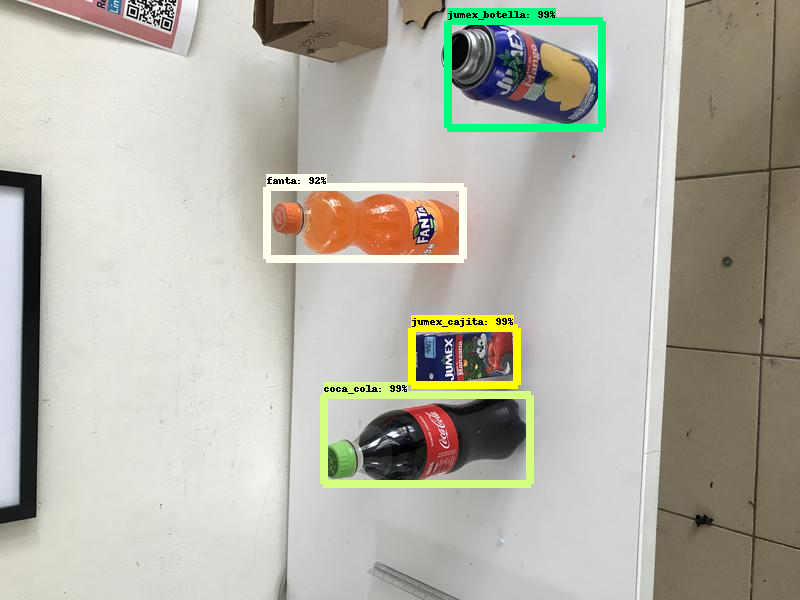

In [31]:
import os
import cv2
import numpy as np
import tensorflow as tf
import sys

from utils import label_map_util
from utils import visualization_utils as vis_util

from google.colab.patches import cv2_imshow

# sys.path.append("..")

# Name of the directory containing the object detection module we're using
MODEL_NAME = 'inference_graph'
IMAGE_NAME = 'test_images/image3.jpg'

# Grab path to current working directory
CWD_PATH = os.getcwd()

PATH_TO_CKPT = os.path.join(CWD_PATH,MODEL_NAME,'frozen_inference_graph.pb')

PATH_TO_LABELS = os.path.join(CWD_PATH,'training','labelmap.pbtxt')

PATH_TO_IMAGE = os.path.join(CWD_PATH,IMAGE_NAME)

NUM_CLASSES = 4

# Load the label map.
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Load the Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    sess = tf.Session(graph=detection_graph)

# Define input and output tensors (i.e. data) for the object detection classifier

# Input tensor is the image
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Output tensors are the detection boxes, scores, and classes
# Each box represents a part of the image where a particular object was detected
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represents level of confidence for each of the objects.
# The score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

# Number of objects detected
num_detections = detection_graph.get_tensor_by_name('num_detections:0')

# Load image using OpenCV
image = cv2.imread(PATH_TO_IMAGE)
image_expanded = np.expand_dims(image, axis=0)

# Perform the actual detection by running the model with the image as input
(boxes, scores, classes, num) = sess.run(
    [detection_boxes, detection_scores, detection_classes, num_detections],
    feed_dict={image_tensor: image_expanded})

# Draw the results of the detection (aka 'visulaize the results')
vis_util.visualize_boxes_and_labels_on_image_array(
    image,
    np.squeeze(boxes),
    np.squeeze(classes).astype(np.int32),
    np.squeeze(scores),
    category_index,
    use_normalized_coordinates=True,
    line_thickness=8,
    min_score_thresh=0.60)

# Display the results image.
cv2_imshow(image)

# Press any key to close the image
cv2.waitKey(0)

# Clean up
cv2.destroyAllWindows()